## Machine Learning - CSE-6363
**Principal Component Analysis**    
**Jesus A. Gonzalez**    
**July-26-2019**    

In [1]:
import pandas as pd
import numpy as np
import urllib.request
import math
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA

In [3]:
# load the CSV file as a numpy matrix
dataset = pd.read_csv(filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
    header=None, 
    sep=',')
dataset.columns = ['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
print(dataset.shape)
print(dataset.head())
print(dataset.tail())

(150, 5)
   sepal_len  sepal_wid  petal_len  petal_wid        class
0        5.1        3.5        1.4        0.2  Iris-setosa
1        4.9        3.0        1.4        0.2  Iris-setosa
2        4.7        3.2        1.3        0.2  Iris-setosa
3        4.6        3.1        1.5        0.2  Iris-setosa
4        5.0        3.6        1.4        0.2  Iris-setosa
     sepal_len  sepal_wid  petal_len  petal_wid           class
145        6.7        3.0        5.2        2.3  Iris-virginica
146        6.3        2.5        5.0        1.9  Iris-virginica
147        6.5        3.0        5.2        2.0  Iris-virginica
148        6.2        3.4        5.4        2.3  Iris-virginica
149        5.9        3.0        5.1        1.8  Iris-virginica


In [4]:
# Split the data into data samples "X" and the class labels "y"
X = dataset.loc[:,'sepal_len':'petal_wid']
y = dataset.loc[:,'class']

In [9]:
X.head()

,sepal_len,sepal_wid,petal_len,petal_wid
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [11]:
y.unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

Our dataset is in the form of a matrix. Each row of the matrix is a sample and each column represents a feature. We have 150 training samples and 4 features.
    - Feature 1: sepal length
    - Feature 2: sepal width
    - Feature 3: petal length
    - Feature 4: petal width

# A Quick Exploratory Analysis
Let us look how separable are the classes according to each of the four attributes:    
    - Sepal length and sepal width do not make a good work separating the classes, their values overlap
    - Petal length and petal width do a better job but not perfect

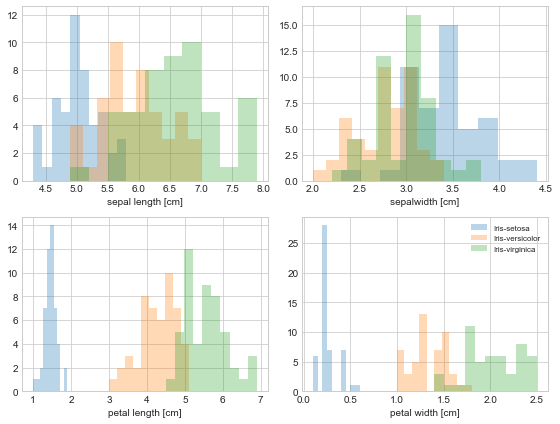

In [4]:
label_dict = {1: 'Iris-Setosa', 2: 'Iris-Versicolor', 3: 'Iris-Virgnica'}
feature_dict = {0: 'sepal length [cm]', 1: 'sepalwidth [cm]', 2: 'petal length [cm]', 3: 'petal width [cm]'}

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    for cnt in range(4):
        plt.subplot(2, 2, cnt+1)
        for lab in ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'):
            plt.hist(dataset[dataset['class']==lab][dataset.columns[cnt]], #X[y==key, col]       #X[y==lab, cnt],
                     label=lab,
                     bins=10,
                     alpha=0.3,)
        plt.xlabel(feature_dict[cnt])
    plt.legend(loc='upper right', fancybox=True, fontsize=8)

    plt.tight_layout()
    plt.show()

# Now we standardize the data

In [5]:
X_std = StandardScaler().fit_transform(X)

# Eigendecomposition Process
    - The eigenvectors represent the directions of the new feature space
    - The eigenvalues determine the magnitude of the eigenvectors
    - We start with the covariance matrix 
    
$\sigma_{jk} = \frac{1}{n-1}\sum_{i=1}^{N}(x_{ij}-\bar{x}_{j})(x_{ik}-\bar{x}_{k})$

$Cov = \frac{1}{n-1}((X-\bar{x})^T(X-\bar{x}))$

where $\bar{x}$ is the mean vector $\bar{x} = \sum_{x=1}^{n}x_i$.
    
    
    
        

In [6]:
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
#cov_mat = np.cov(X_std.T) # We can also use numpy to compute the covariance matrix as we do in this line
print('Covariance matrix \n%s' %cov_mat)

# Now we get the eigenvalues and the eigenvectors:

eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('\nEigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Covariance matrix 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[2.93035378 0.92740362 0.14834223 0.02074601]


**Now we sort the eigenvalues (and eigenvectors) from highest to lowest so that 
we can choose the top k eigen vectors and then reduce the dimensionality.**

In [7]:
# We make tuples of (eigenvalue, eigenvector)
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the tuples in descending order
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Verify our results:
print('Eigenvalues in descending order:')
count = 1
for i in eig_pairs:
    print(str(count) + ".  " + str(i[0]))
    count+=1

Eigenvalues in descending order:
1.  2.9303537755893156
2.  0.9274036215173417
3.  0.14834222648163986
4.  0.02074601399559581


# Explained Variance
In PCA we select the top k components of the new space. All the components in the new space explain 100% of the variance in the data and the k top components explain a smaller percentage of the variance. Here is how we compute the **explained variance** according to how many components we choose. In this example we can see that the first component  explains 73% of the variance, the second 23%, and the third one only about 4%. We could then take the first and second components and drop the rest of them without loosing too much information.

[0.007277045209380133, 0.002303052326768065, 0.000368383195762739, 5.151926808906293e-05]


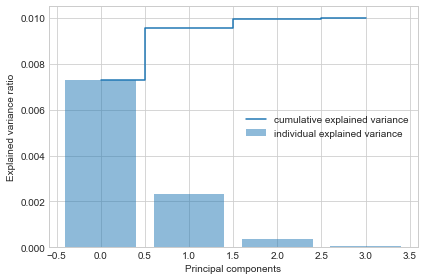

In [8]:
total_variance = sum(eig_vals)
var_exp = [(i/total_variance)/100 for i in sorted(eig_vals, reverse=True)]
print(var_exp)
cum_var_exp = np.cumsum(var_exp)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(4), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(4), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# The Projection Matrix
Now we need to create the projection matrix that we will use to 
transform the dataset into the new feature space. This is the
matrix of the concatenated top $k$ eigenvectors.

In [9]:
# We get the eigenvectors corresponding to the first two (top) eigenvalues
# to create matrix W.
matrix_w = np.hstack((eig_pairs[0][1].reshape(4,1),
                      eig_pairs[1][1].reshape(4,1)))

print('Matrix W:\n', matrix_w)

Matrix W:
 [[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]


# Projection Onto the New Feature Space
Now we use our 4x2 projection matrix W to transform our samples onto the new subspace using the equation:
$Y = X \times W$. where $Y$ is a 150 $\times$ 2 matrix, our transformed samples.

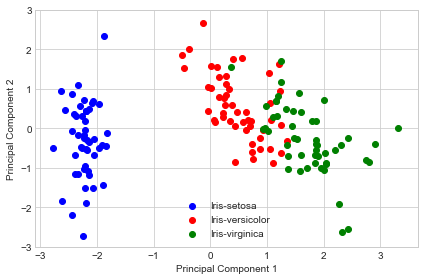

In [10]:
Y = X_std.dot(matrix_w)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'), 
                        ('blue', 'red', 'green')):
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

# The Same PCA process but using the Scikit-learn library

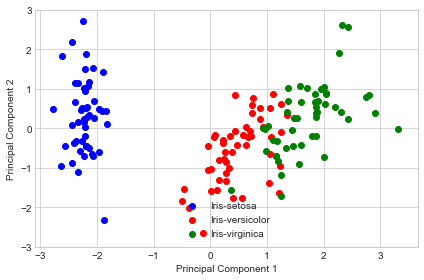

In [12]:
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'), 
                        ('blue', 'red', 'green')):
        plt.scatter(Y_sklearn[y==lab, 0],
                    Y_sklearn[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

# References
- [PCA Jupyter Notebook by Sebastian Raschka](https://nbviewer.jupyter.org/github/rasbt/pattern_classification/blob/master/dimensionality_reduction/projection/principal_component_analysis.#PCA-and-Dimensionality-Reduction)